# Image processing tutorial

In this notebook, we provide a tutorial of how to properly call the functions build to extract various biofilm features. This includes :

- Extracting the wrinkle class
- Computing the percentage of wrinkle area
- Computing the number of spokes present in the biofilm, the medium length of the spokes and the medium distance of the spokes from the center
- Computing the average distance from spokes to the center of the biofilm


You will find all the necessary functions in the `.py` file `image_processing_functions.py`

In [32]:
# Additional python packages

from __future__ import print_function

from time import time
import logging
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
from ggplot import *
import umap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.manifold import TSNE

from image_processing_functions import * # Our functions


## Loading the data

For this tutorial, we will work on 6 different 5 days old biofilm images, all of each mutant.

In [3]:
day = 5
index = 1
size = 500
path = '/home/khalana/GitRepos/dsi-capstone/final_dataset/'
images = {}
names = []
for mutant in ['cco1cco2', 'dipA','pas9','phz','rmcA', 'wt']:
    name = '{}_{}_{}'.format(mutant, day, index)
    names.append(name)
    img_path = path + name + '.jpg'
    img = Image.open(img_path)
    img = img.resize((size, size))
    arr = np.array(img).astype('uint8')
    images[name] = arr
dic_features = {'biofilm' : names}

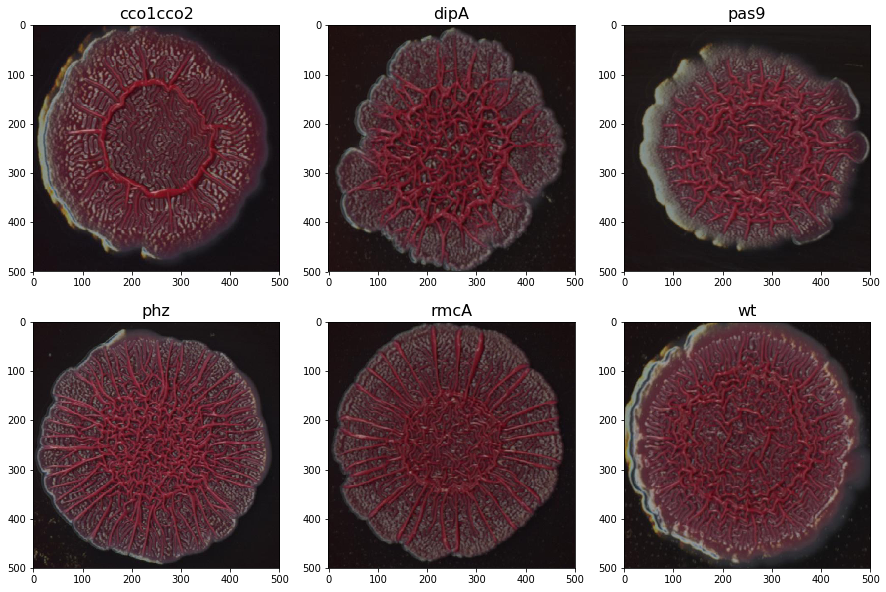

In [4]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images[names[k]])
        axarr[i,j].set_title(names[k].split('_')[0], fontsize=16)
        k += 1

## Getting the wrinkle class

In [5]:
images_wrinkle_class = {}
for name in names :
    images_wrinkle_class[name] = get_wrinkles(images[name], resize = size, background_is_black = True)

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: divide by zero encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1] / X[:,2])) < 0.75) & (X[:,1] < 80) & (X[:,2] < 80) & ((X[:,0]/ (X[:,1] +  X[:,2])) > 1.0)


### Plotting wrinkle class

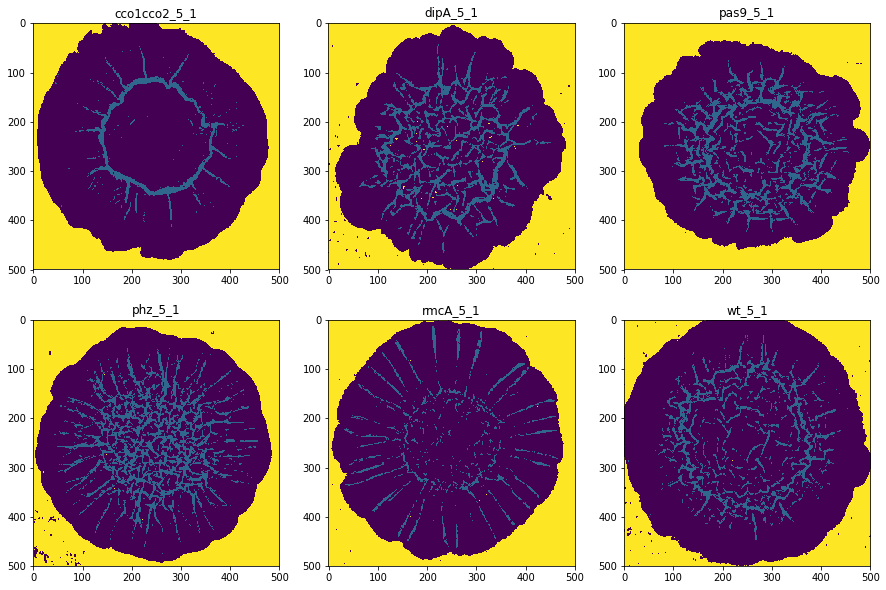

In [5]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images_wrinkle_class[names[k]][1])
        axarr[i,j].set_title(names[k])
        k += 1

### Computing percent wrinkled

In [6]:
percent_wrinkled = []
for name in names :
    percent_wrinkled.append(perc_wrinkled(images_wrinkle_class[name][0]))

dic_features['percent_wrinkled'] = percent_wrinkled

df_features = pd.DataFrame.from_dict(dic_features)
df_features

biofilm  percent_wrinkled
0  cco1cco2_5_1              5.91
1      dipA_5_1             15.36
2      pas9_5_1             17.41
3       phz_5_1             18.64
4      rmcA_5_1              7.14
5        wt_5_1             10.90

## Detecting the spokes

In [7]:
images_spokes = {}
for name in names :
    images_spokes[name] = detect_spokes(images[name], img_wrinkle=images_wrinkle_class[name][1], resize = size)[0]

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])


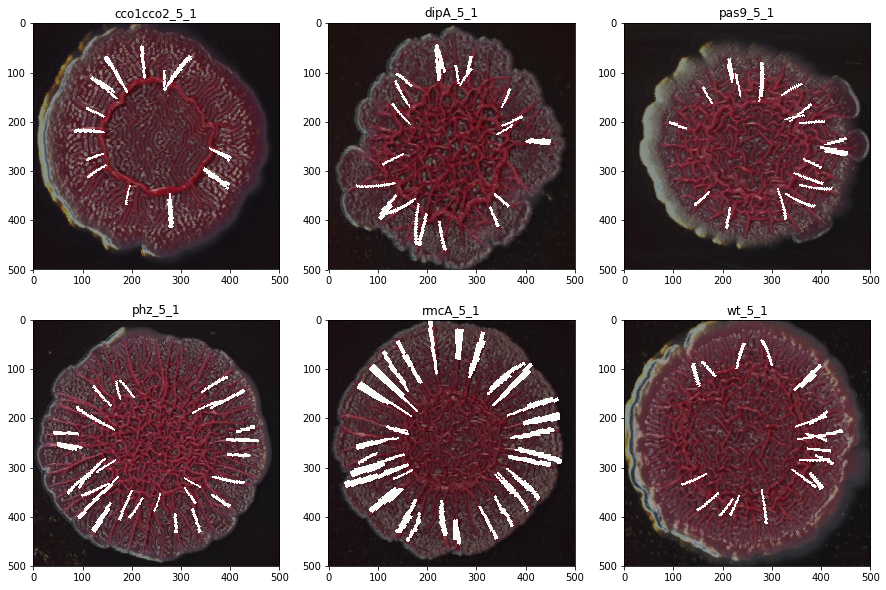

In [8]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images_spokes[names[k]])
        axarr[i,j].set_title(names[k])
        k += 1

### Computing number of spokes, median length of spokes and medium distance from center

In [11]:
n_spokes = []
median_spokes_length = []
median_dist_center = []
for name in names :
    _, n_spoke, median_length, median_dist = detect_spokes(images[name], img_wrinkle=images_wrinkle_class[name][1], resize = size)
    n_spokes.append(n_spoke)
    median_spokes_length.append(median_length)
    median_dist_center.append(median_dist)

dic_features['n_spokes'] = n_spokes
dic_features['median_spokes_length'] = median_spokes_length
dic_features['median_dist_center'] = median_dist_center

df_features = pd.DataFrame.from_dict(dic_features)
df_features

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])


biofilm  percent_wrinkled  n_spokes  median_spokes_length  \
0  cco1cco2_5_1              5.91        22             68.103300   
1      dipA_5_1             15.36        25             65.375837   
2      pas9_5_1             17.41        21             64.195015   
3       phz_5_1             18.64        33             70.114193   
4      rmcA_5_1              7.14        84             88.511362   
5        wt_5_1             10.90        22             63.899552   

   median_dist_center  
0               158.0  
1               181.0  
2               144.0  
3               155.0  
4               170.5  
5               150.0

# Data exploration

## Loading all 4 and 5 days images

In [7]:
all_images={}
all_names=[]
for root, dirs, files in os.walk(path):
    for name in files:
        if int(name.split('_')[1]) > 3:
            mypath = os.path.join(root,name)
            img = Image.open(mypath, mode = 'r')
            img = img.resize((size, size))
            arr = np.array(img).astype('uint8')
            all_images[name.split('.')[0]] = arr
            img.close()
            all_names.append(name.split('.')[0])
            
dic_features = {'biofilm' : all_names}


## Extracting all features

In [17]:
percent_wrinkled = []
n_spokes = []
median_spokes_length = []
median_dist_center = []
all_images_wrinkle_class = {}
for name in all_names :
    all_images_wrinkle_class[name] = get_wrinkles(all_images[name], resize = size, background_is_black = True)
    percent_wrinkled.append(perc_wrinkled(all_images_wrinkle_class[name][0]))
    _, n_spoke, median_length, median_dist = detect_spokes(all_images[name],img_wrinkle=all_images_wrinkle_class[name][1], resize = size)
    n_spokes.append(n_spoke)
    median_spokes_length.append(median_length)
    median_dist_center.append(median_dist)

dic_features['percent_wrinkled'] = percent_wrinkled
dic_features['n_spokes'] = n_spokes
dic_features['median_spokes_length'] = median_spokes_length
dic_features['median_dist_center'] = median_dist_center

df_features = pd.DataFrame.from_dict(dic_features)

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: divide by zero encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1] / X[:,2])) < 0.75) & (X[:,1] < 80) & (X[:,2] < 80) & ((X[:,0]/ (X[:,1] +  X[:,2])) > 1.0)
/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: invalid value encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1

In [18]:
df_features['mutant'] = [name.split('_')[0] for name in df_features.biofilm]
df_features['day'] = [int(name.split('_')[1]) for name in df_features.biofilm]
df_features.to_csv('final_dataset_features.csv')

Clusters of different mutants are visible in this scatterplot.

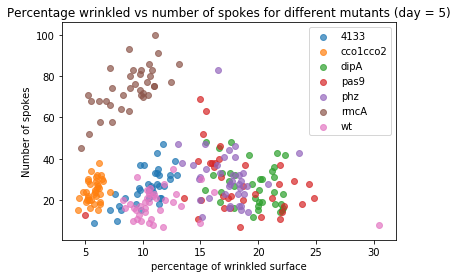

In [19]:
day = 5
fig, ax = plt.subplots()
for mutant in np.unique(df_features.mutant):
    data = df_features[(df_features.mutant == mutant) & (df_features.day == day)]
    ax.scatter(data.percent_wrinkled, data.n_spokes,  label = mutant, alpha = 0.7)
ax.set_xlabel("percentage of wrinkled surface")
ax.set_ylabel("Number of spokes")
ax.legend()
plt.title('Percentage wrinkled vs number of spokes for different mutants (day = {})'.format(day))
plt.show()

## PCA + SVN  on 4 and 5 days images

In this part, we train a SVM that aims at predicting the mutant on day 4 and 5 images. First, we preprocess the raw image data using PCA, and keep the 50 most important components, and then train the SVM on this preprocessed data. With this method, we get a 0.83 f1-score on the test set.

In [20]:
tsne_names = []
tsne_data = []
for name in all_images:
    if int(name.split('_')[1])>3:
        tsne_data.append(all_images[name])
        tsne_names.append(name)
labels = np.array([name.split('_')[0] for name in tsne_names])

In [21]:
X = [x.flatten() for x in tsne_data]
X = np.asarray(X)

In [22]:
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)
print("done in %0.3fs" % (time() - t0))


print("Projecting the input data on the eigen orthonormal basis")
t0 = time()

X_pca = pca.transform(X)
print("done in %0.3fs" % (time() - t0))

Extracting the top 50 eigenvectors from 512 biofilms
done in 18.964s
Projecting the input data on the eigen orthonormal basis
done in 1.642s


In [23]:
feat_cols = [ 'pixel'+str(i) for i in range(X_pca.shape[1]) ]

df = pd.DataFrame(X_pca,columns=feat_cols)
df['label'] = labels

X, y = None, None


print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (512, 51)


In [24]:
rndperm = np.random.permutation(df.shape[0])

n_sne = 1000

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 1.663233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.020767
[t-SNE] KL divergence after 300 iterations: 2.345457
t-SNE done! Time elapsed: 0.7502577304840088 seconds


In [25]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [30]:

p = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.6) \
        + ggtitle("tSNE dimensions colored by gene")\
        + theme_bw() 

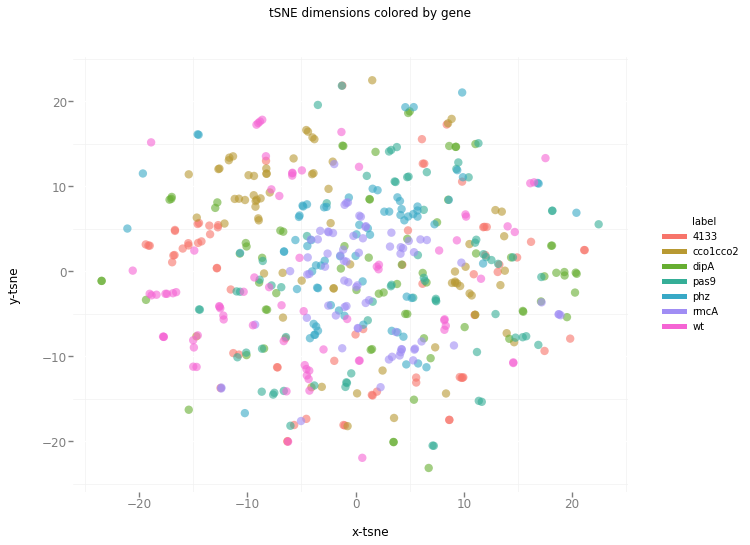

<ggplot: (-9223363293682562749)>

In [31]:
p


In [33]:
umap_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.001,
                      metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

### Parameter Search

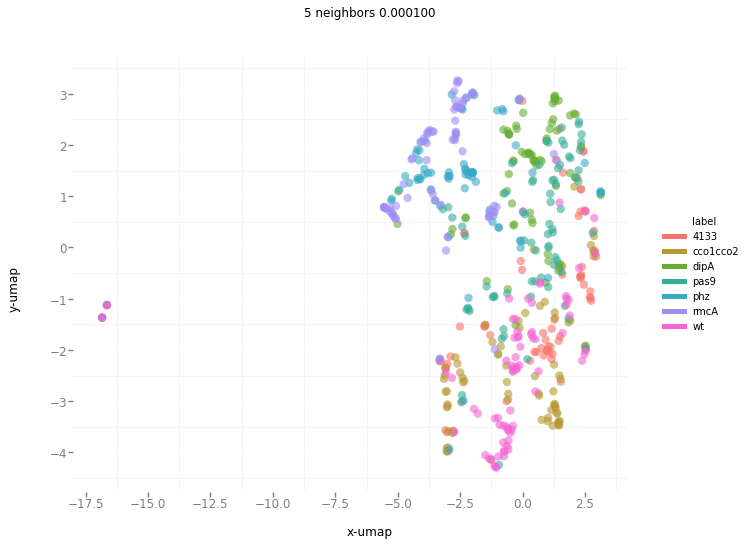

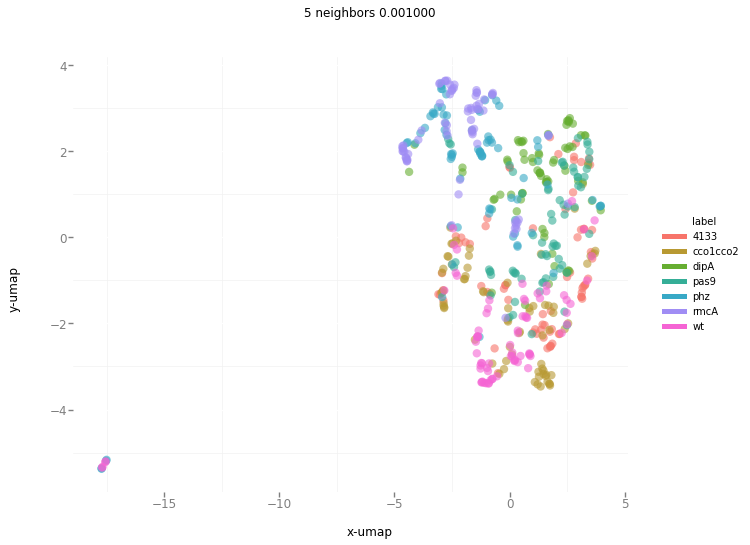

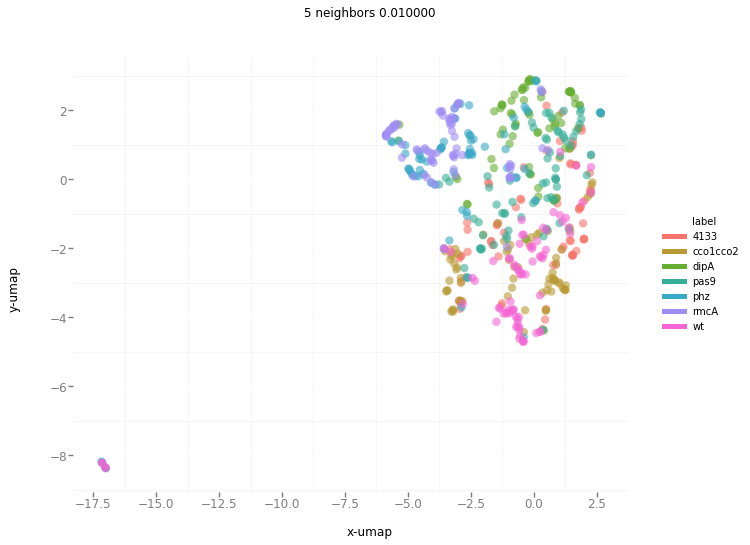

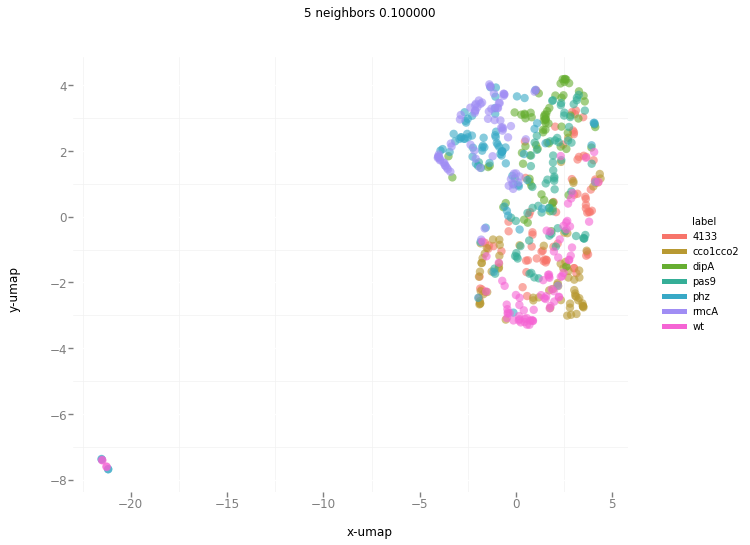

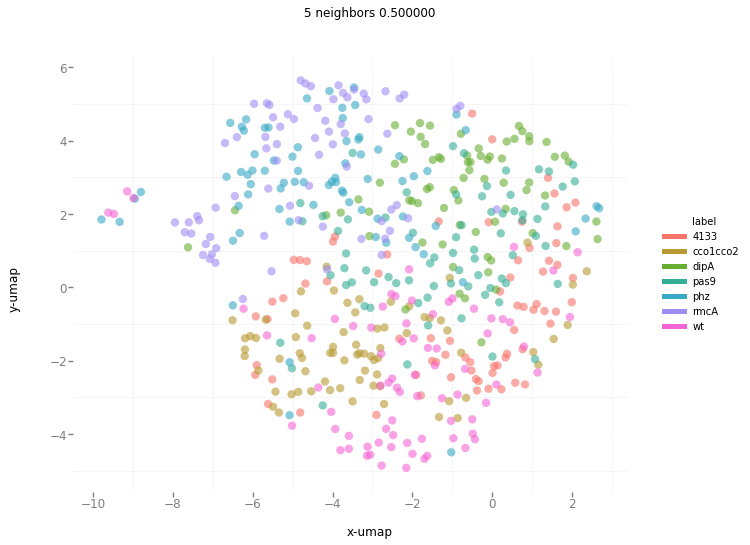

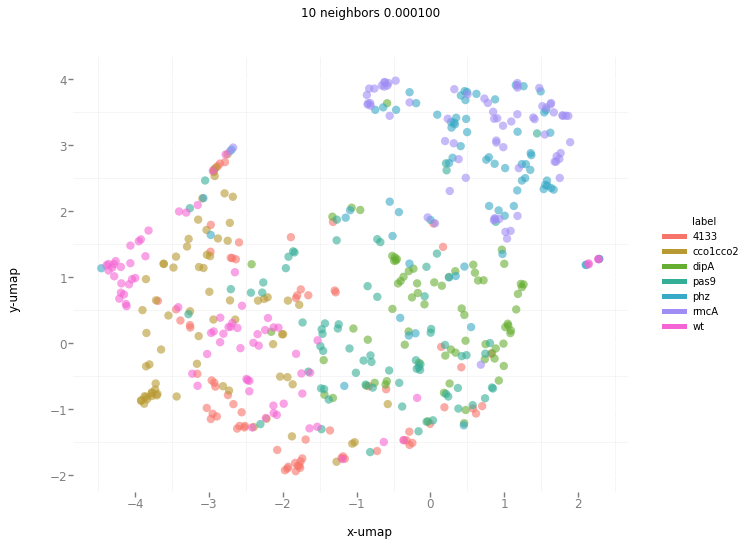

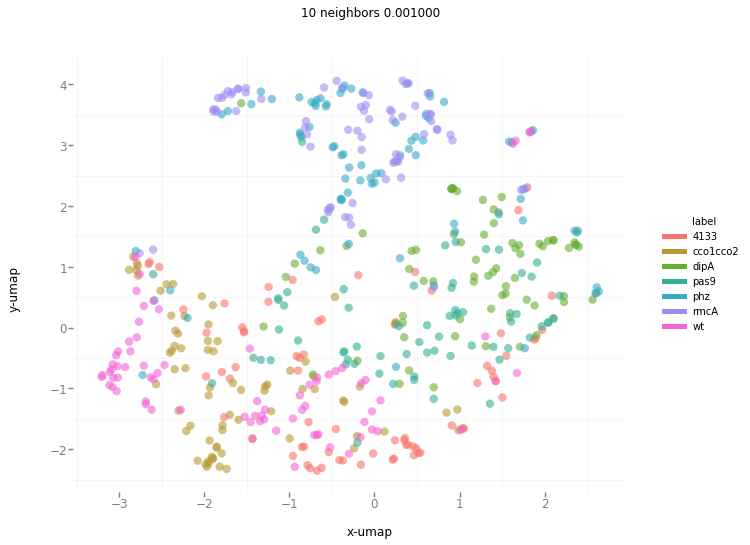

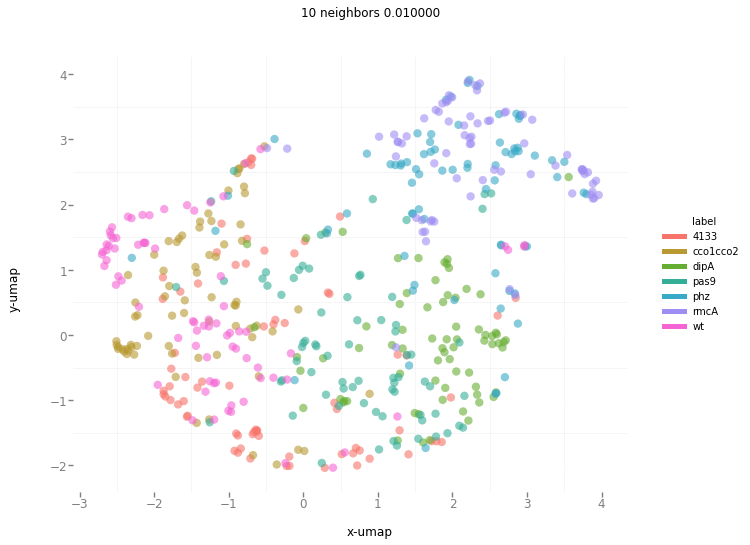

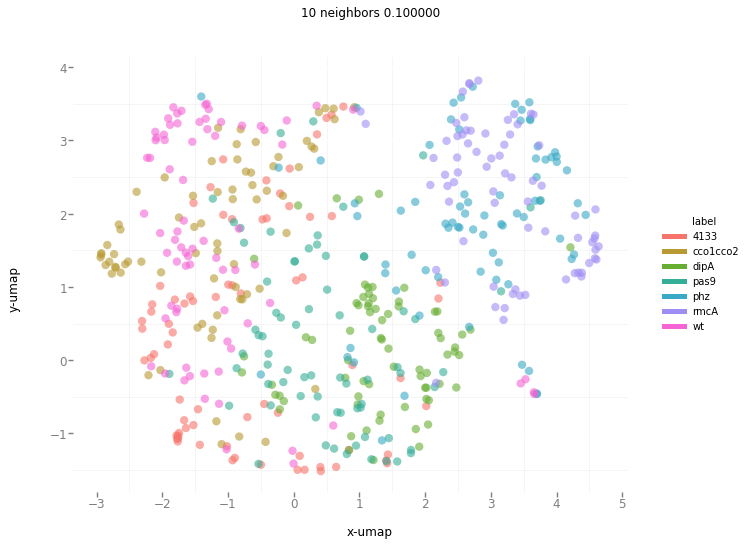

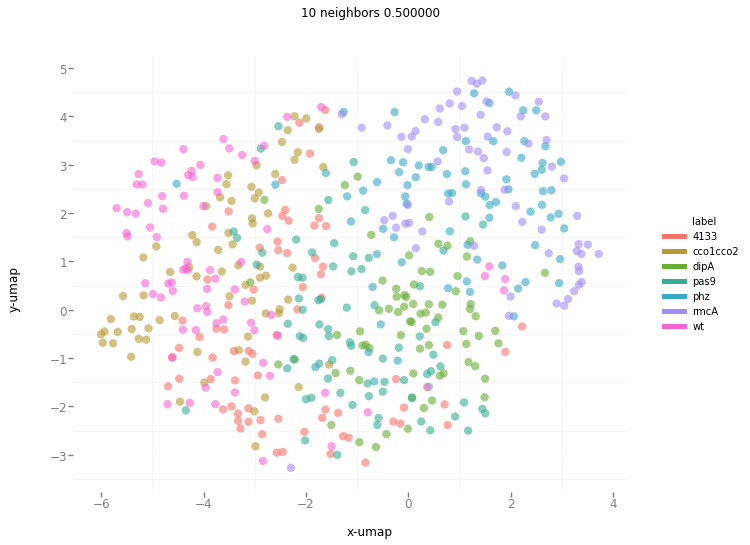

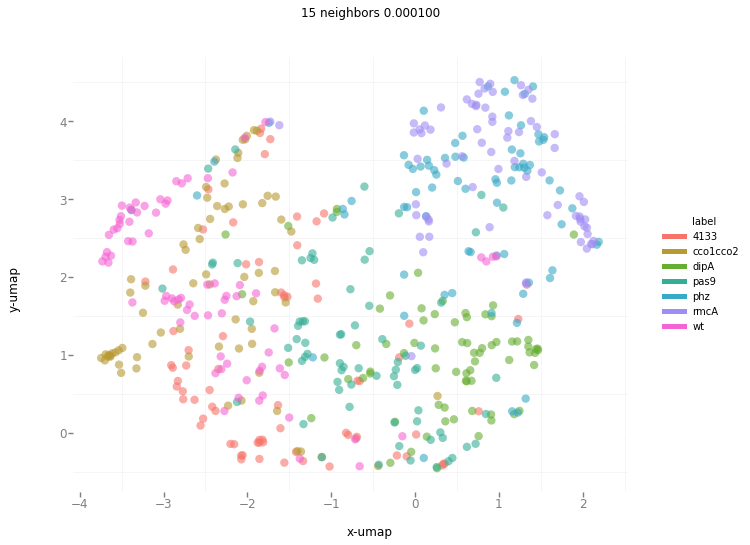

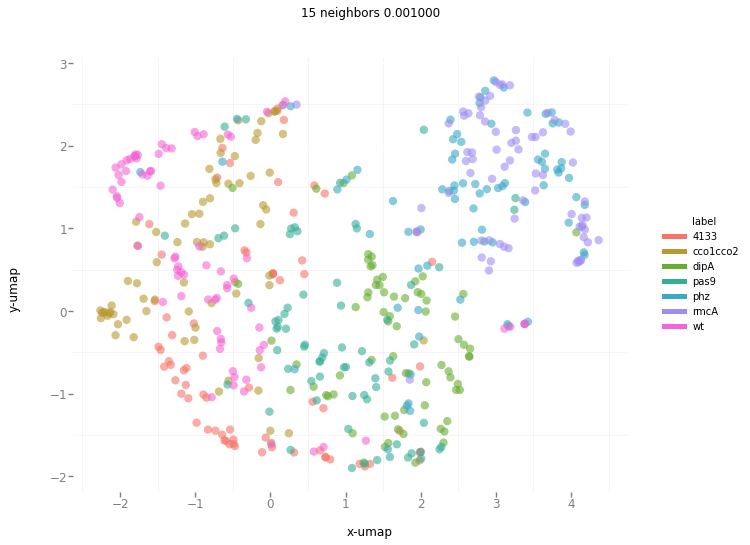

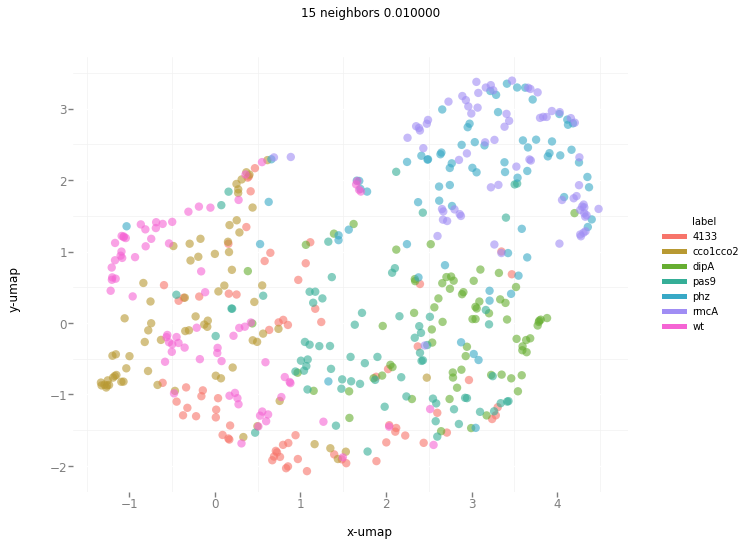

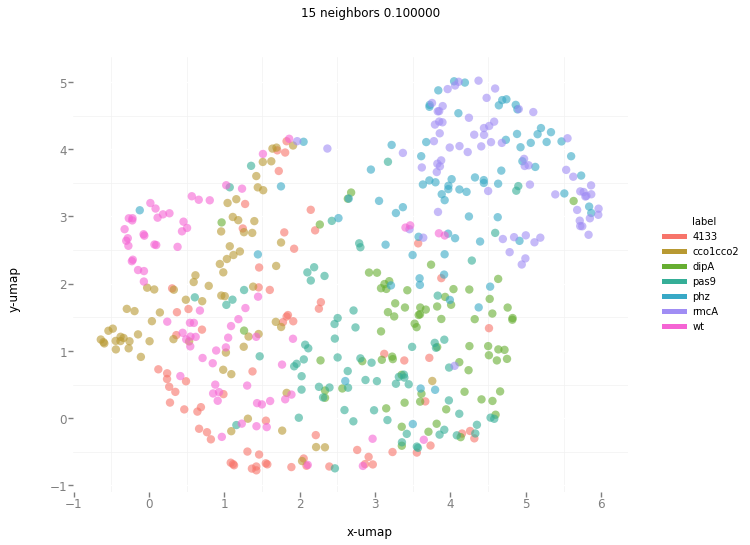

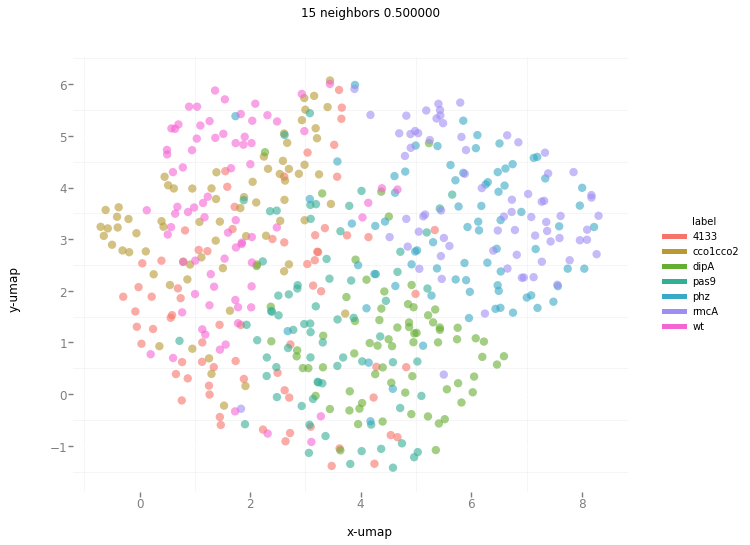

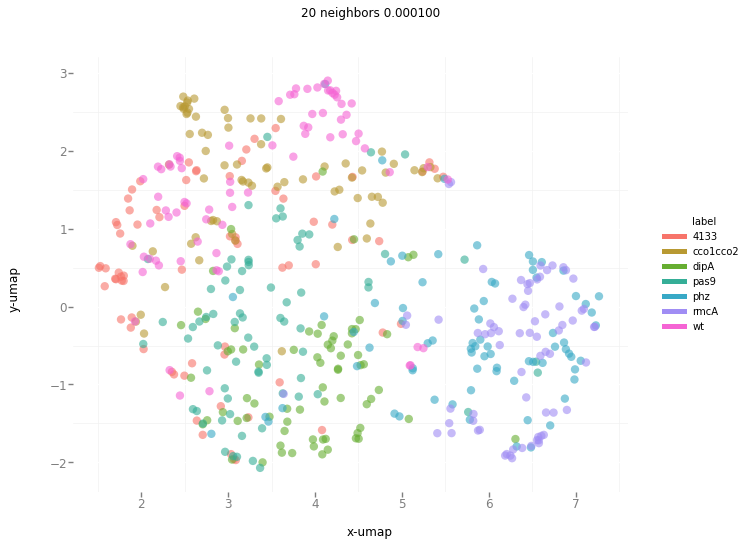

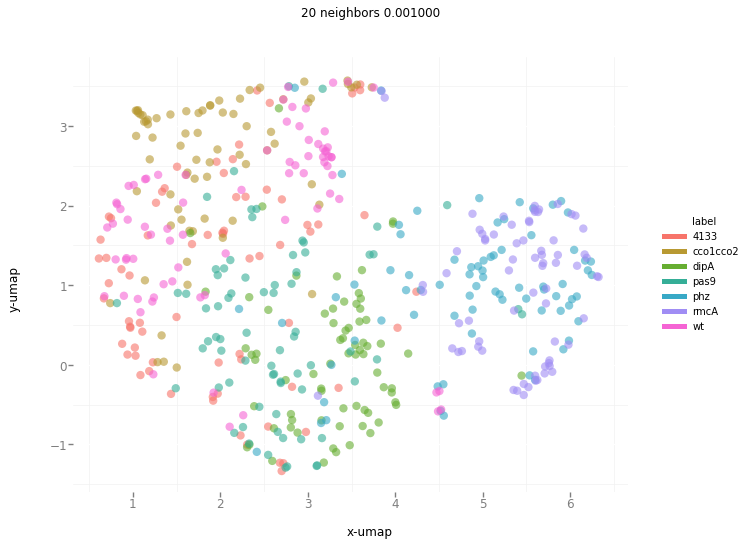

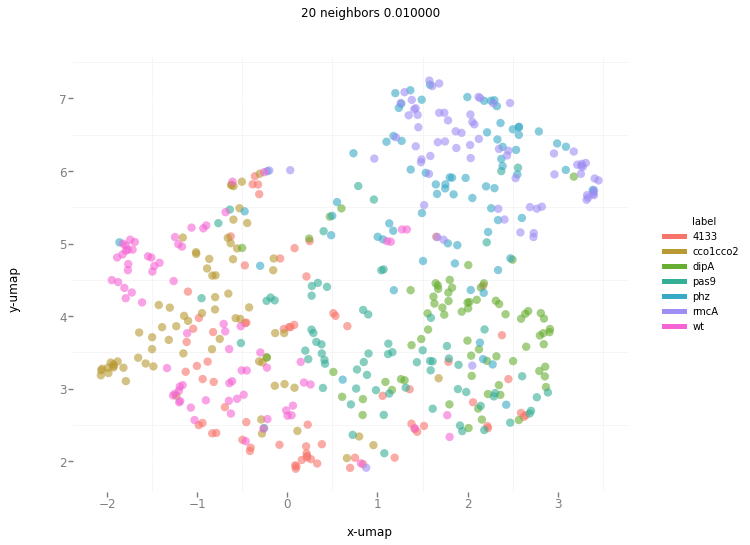

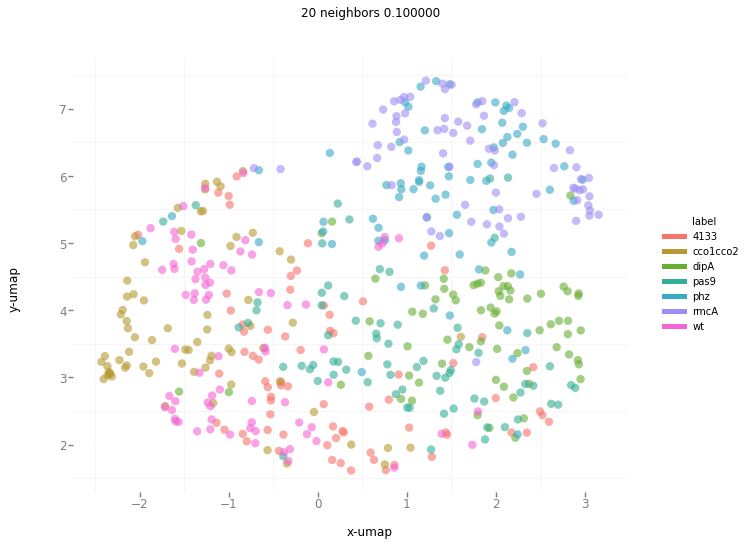

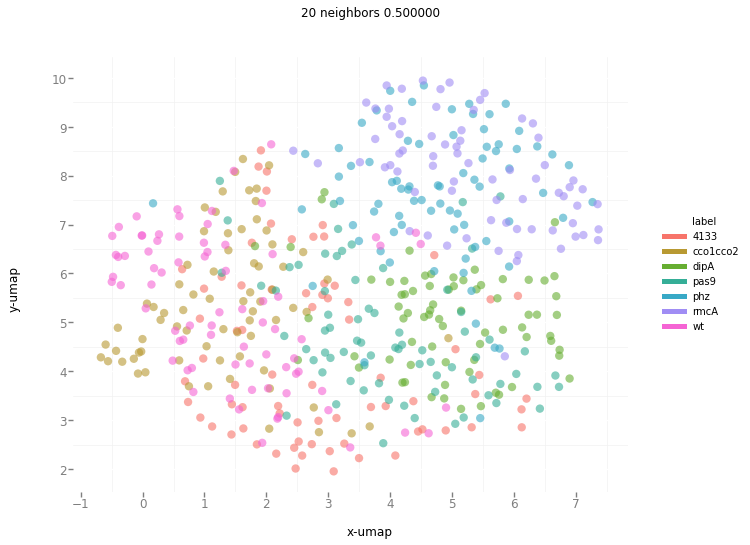

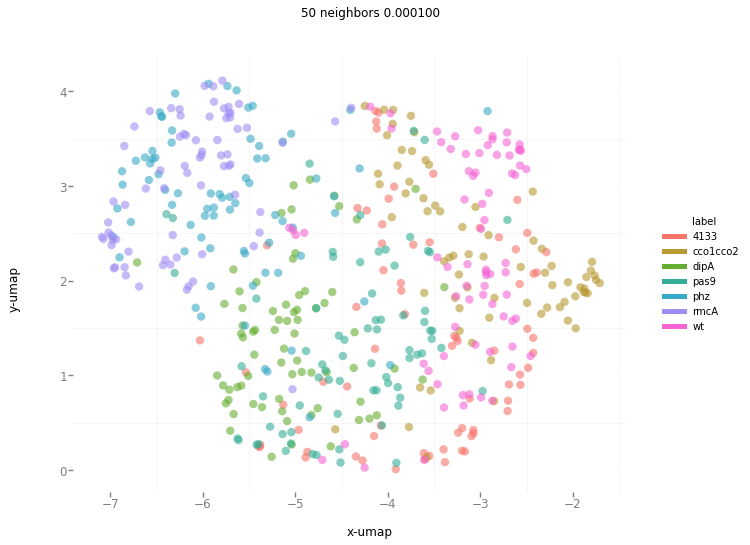

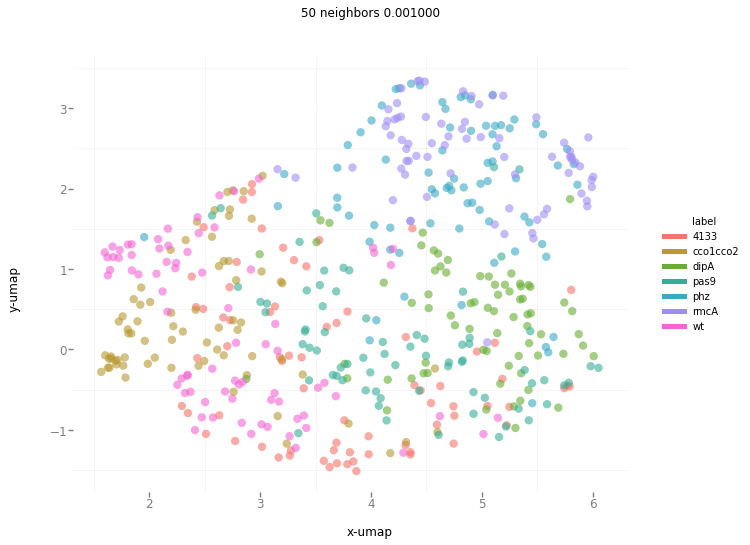

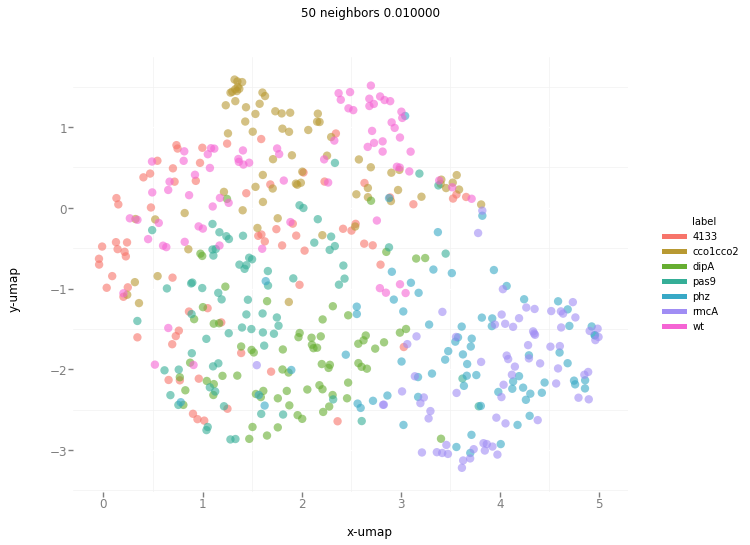

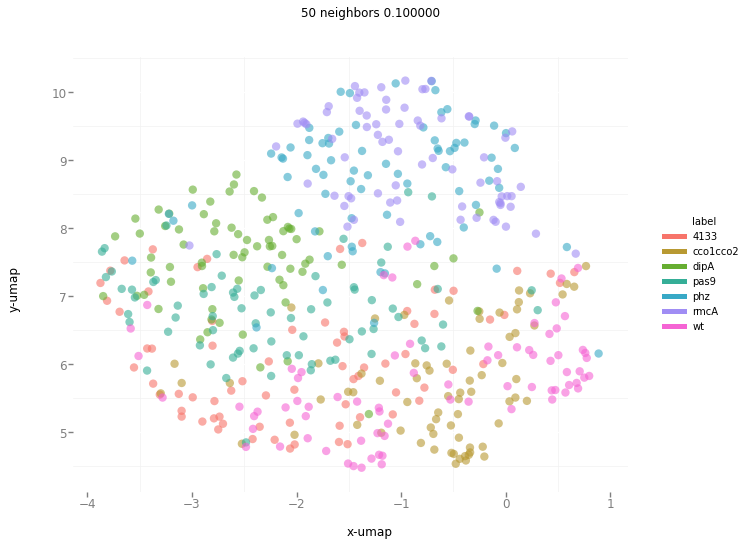

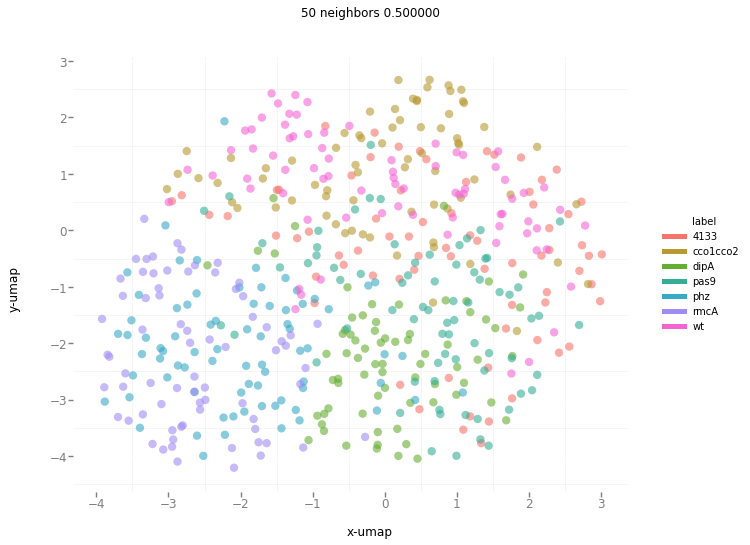

In [34]:
for n in [5,10,15,20,50]:
    for m in [.0001, .001, .01, .1, .5]:
        umap_embedding = umap.UMAP(n_neighbors=n,
                          min_dist=m,
                          metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
        df_umap = df.loc[rndperm[:n_sne],:].copy()
        df_umap['x-umap'] = umap_embedding[:,0]
        df_umap['y-umap'] = umap_embedding[:,1]
        p = ggplot( df_umap, aes(x='x-umap', y='y-umap', color='label') ) \
            + geom_point(size=70,alpha=0.6) \
            + ggtitle("%d neighbors %f" %(n,m)) \
            + theme_bw()
        p.show()

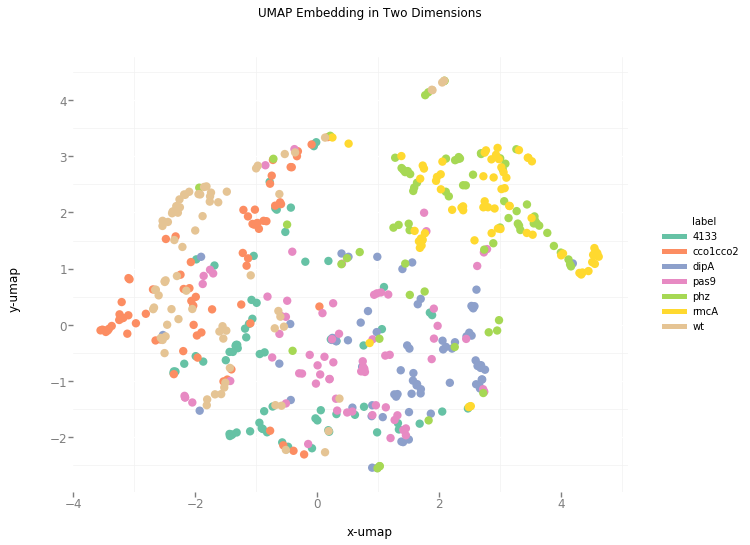

In [38]:
umap_embedding = umap.UMAP(n_neighbors=7,
                  min_dist=.005,
                  metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
df_umap = df.loc[rndperm[:n_sne],:].copy()
df_umap['x-umap'] = umap_embedding[:,0]
df_umap['y-umap'] = umap_embedding[:,1]
p = ggplot( df_umap, aes(x='x-umap', y='y-umap', color='label') ) \
    + geom_point(size=70,alpha=1) \
    + ggtitle("UMAP Embedding in Two Dimensions") \
    + theme_bw() \
    + scale_color_brewer(type='qual', scheme='Dark',palette=7, n=7)
p.show()

In [39]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(tsne_data, labels, test_size=0.25, random_state=42)

X_train = np.array([x.flatten() for x in X_train])
X_test = np.array([x.flatten() for x in X_test])




# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))


print("Projecting the input data on the eigen orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting mutant type based on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))#, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Automatically created module for IPython interactive environment
Extracting the top 50 eigenvectors from 384 biofilms
done in 11.887s
Projecting the input data on the eigen orthonormal basis
done in 1.776s
Fitting the classifier to the training set
done in 3.770s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting mutant type based on the test set
done in 0.004s
              precision    recall  f1-score   support

        4133       0.83      0.79      0.81        19
    cco1cco2       1.00      0.75      0.86        20
        dipA       0.89      0.53      0.67        15
        pas9       0.71      1.00      0.83        17
         phz       0.75      0.88      0.81        17
        rmcA       0.96      1.00      0.98        24
          wt       0.88    

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Data augmentation

The biofilm labels are invariant by rotation and transposition. It is therefore easily multiply the size of our training dataset by 8: 4 rotations * 2 transpose. We therefore use this method to improve our SVM. We  fit the PCA on the non-expanded train set for computation efficiency. With this method, our f1 score on the train set jumps from 83% to 90%.

In [45]:
from tqdm import tqdm 

In [46]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Split into a training set and a test set using a stratified k fold



## #############################################################################
# Expand our training set
X_expanded = []
y_expanded = []
rotation = [0, 90, 180, 270]
for i, x in tqdm(enumerate(tsne_data)):
    for angle in rotation:
        img = Image.fromarray(x)
        img_rotate = img.rotate(angle)
        img_transpose = img_rotate.transpose(Image.FLIP_LEFT_RIGHT)
        arr_rotate = np.array(img_rotate).astype('uint8')
        arr_transpose = np.array(img_transpose).astype('uint8')
        X_expanded.append(arr_rotate)
        X_expanded.append(arr_transpose)
        y_expanded.append(labels[i])
        y_expanded.append(labels[i])

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_expanded, y_expanded, test_size=0.25, random_state=42)

        
# flatten
X_train = np.array([x.flatten() for x in X_train_expanded])
X_test = np.array([x.flatten() for x in X_test])

# shuffle 

indices = np.arange(len(X_train_expanded))
np.random.shuffle(indices)
X_train_expanded = X_train_expanded[indices]
y_train_expanded = np.array(y_train_expanded)[indices]



18it [00:00, 178.33it/s]

Automatically created module for IPython interactive environment


512it [00:03, 149.37it/s]


In [53]:


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))


print("Projecting the input data on the eigen orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train_expanded)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train_expanded)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting mutant type based on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))#, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Extracting the top 50 eigenvectors from 3072 biofilms


MemoryError: 